# Assignment 2: SoC Module Recommender System

## Instructions to submit the assignment

- Name your jupyter notebook as `Assignment2_[StudentID].ipynb`. For instance: `Assignment2_A0123873A.ipynb`
- Your solution notebook must contain the python code that we can run to verify the answers.
- Upload your jupyter notebook on LumiNUS in the *Assignment 1 Submissions* folder. The folder will close at 4pm on 02/04/2021. Late submissions will receive a penalty on the grade as follows:
  - late within 1 hour: 10% reduction in grade
  - late within 6 hours: 30% reduction in grade
  - late within 12 hours: 50% reduction in grade
  - late within 1 days: 70% reduction in grade
  - after 1 days: zero mark
- **This is an individual assessment. Refrain from working in groups.**

In this assignment we design a reccomendation engine. The recommendation engine suggests the students a module that closely matches the modules already taken by the student. The dataset comprices of two files:
- List of modules in the School of Computing 
- List of graduated students and the modules they had taken during their studies

# Loading the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import  TransformerMixin
'''
    YOU MUST USE THE RANDOM SEED WHEREVER NEEDED
'''
rng = np.random.default_rng(seed=42)

courses = pd.read_csv("courses.tsv", sep='\t')
students = pd.read_csv("students.tsv", sep='\t')


In [2]:
courses.specialisation.unique()
# 1 typo Netoworking
courses.specialisation = courses.specialisation.replace('Netoworking','Networking')
courses.specialisation.unique()


array(['Core', 'DB', 'SE', 'PL', 'Networking', 'Multimedia', 'Security',
       nan, 'Parallel', 'Parallel, PL', 'Graphics', 'Algo', 'PL, SE',
       'AI', 'AI, DB', 'Algo, Networking, Parallel', 'Security, SE',
       'AI, Graphics', 'AI, Multimedia', 'Algo, Security', 'AI, PL',
       'Networking, Parallel', 'Algo, Graphics', 'Graphics, Multimedia',
       'DB, Security'], dtype=object)

# Question 1: Creating the preprocessing pipeline

We want to create a sklearn pipeline to efficiently preprocess the data and prepare it for training a model. We use three different features in the `courses` data: `specialisation`, `info` and `workload`. We want to represent every feature in a numeric form and merge them to form a feature vector for every course. We do so in the following way:
- `specialisation` represents one of the six levels of the module. For instance: CS2103 is a Software Engineering (SE) specialisation module. Encode this categorical feature into a vector. The decision of handling missing values is left to you! *(Hint: You can use `MultiLabelBinerizer` to do so.)*
- `info` provides a short discription of the module. We want to convert it into a vector using CountVectorizer. *Don't forget to remove the stopwords* while doing so.
-  `workload` states the intended distribution of workload over lectures, tutorials, labs and self study. We want to find the workload as the sum of individual workloads. For instnce: 3-1-1-3-2 workload transforms to 10 hours.

Provide implementation for three classes that help us build the pipeline. `transformed_courses` should be a numpy array of shape `[n_courses X n_features]`.

                                                                                                   (6 marks)

In [3]:
class WorkloadTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        if 'workload' in X.columns:
            workload_ = X.workload.apply(
                lambda x: sum(map(float, x.split('-'))))
            return np.array(workload_).reshape(-1, 1)
        return self


In [4]:
class InfoTransformer(TransformerMixin):
    
    def __init__(self):
        self.vectorizer = CountVectorizer(
            lowercase=True, stop_words='english', analyzer='word')

    def fit(self, X, y=None, **fit_params):
        if 'info' in X.columns:
            self.vectorizer.fit(X['info'])
        return self

    def transform(self, X, y=None, **fit_params):
        if 'info' in X.columns:
            return self.vectorizer.transform(X['info']).toarray()
        return self



In [5]:
class SpecTransformer:

    def __init__(self):
        self.mlb = MultiLabelBinarizer()
        self.splitString = lambda x: x.split(',')

    def fit(self, X, y=None, **fit_params):
        X_ = [self.splitString(xi[0]) for xi in X]
        self.mlb.fit(X_)
        return self

    def transform(self, X, y=None, **fit_params):
        X_ = [self.splitString(xi[0]) for xi in X]
        return self.mlb.fit_transform(X_)


In [6]:
featureTransformer = FeatureUnion([
    ('workload_processing', Pipeline([('wrkld', WorkloadTransformer())])),
    ('info_processing', Pipeline([('info', InfoTransformer())])),

    # 21 columns
    ('spec_processing', Pipeline([
        ('col_spec', ColumnTransformer([
            ('impute_specialisation', SimpleImputer(
                strategy='constant', fill_value='Other'), ['specialisation'])
        ])),
        ('split', SpecTransformer())
    ])),

])

featureTransformer.fit(courses)
transformeed_courses = featureTransformer.transform(courses)


Now we prepare our testing data in the same way we preprocessed the course. `students` data comprises of 1000 students and a list of modules they have taken. 

Create `Xtest` and `Ytest` as two matrices. `Xtest`, of size `1000*5`, comprises of first five modules for every student in the list. `Ytest`, of size `1000*[remaining_modules]`, comprises of rest of the modules for every student in the list. 
We do so in order to assess the performance of the recommender. We assess the recommender based on its effectiveness to predict the modules given a list of five modules as the input.

For instance: 
- `Xtest[0] = ['CS2105', 'CS4222', 'CS6270', 'CS6205', 'CS4226']`
- `Ytest[0] = ['CS3282', 'CS6204', 'CS5223', 'CS3281', 'CS4344', 'CS5422', 'CS3237', 'CS5233']`.

<div align="right">(1 mark)</align>

In [9]:
# Write your code here
def CoursesSeparator(df):
    courses = df.courses.copy()
    courses= courses.str.split(',')
    Xtest = courses.apply(lambda x: x[:5])
    Ytest = courses.apply(lambda x: x[5:])
    return Xtest, Ytest


Xtest, Ytest = CoursesSeparator(students)


For every student in `Xtest`, we need to transform the list of 5 modules to the feature space using the `featureTransformer` fit on the training data. For every module we will get a feature vector of size `n_features`. We add these feature vectors to get an aggregate feature vector for very student.

Write a function `getFeatureVector` that takes in the list of modules and `featureTransformer`. It returns the feature vector for the specified list of courses. For instance, `getFeatureVector(Xtest[0], featureTransformer)` will return a vector of size `n_features`.

<div align="right">(3 marks)</div>

In [11]:
def getFeatureVector(modules, courses, featureTransformer):
    transformed_courses = featureTransformer.transform(courses)

    def getCourseCode(index):
        course = courses.loc[courses.code == index]
        if course.empty:
            return -1

        return course.index[0]

    indexes = [int(x) for x in map(
        lambda x:getCourseCode(x), modules)]
    indexes = list(filter(lambda x: x >= 0, indexes))
    return np.sum(transformed_courses[indexes, :], axis=0)


for i in range(1,10):
    getFeatureVector(Xtest[i], courses, featureTransformer)


# Question 2: Content based recommender

We can use a model as simple as K-nearest neighbour (KNN) to perform a content based recommendation. If we provide a list of 5 modules to the recommender, it provide us a list of modules that are similar to the specified modules.

`sklearn` provides `NearestNeighbors` as well as `KNeighborsClassifier`, both of which have a similar functionality. `NearestNeighbors` provides as an easy functionality to predict a list of K nearest neighbours. Therefore, we prefer it over `KNeighborsClassifier`. If we want to find K nearest points to a datapoint`d`, we need to use `n_neighbors` as K + 1 because the list includes `d` itself.

You can now train the model using the training data, which comprises of `transformed_courses` and with their codes as the labels. 
<div align="right">(1 mark)</div>

In [14]:
K = 5
model = NearestNeighbors(algorithm="auto", n_neighbors=K)
## Write your code here

training_data = pd.DataFrame(transformeed_courses)
training_data.index = courses.code

model.fit(training_data.values)

NearestNeighbors()

It is time to see our model in action. Let's see what modules our model reommends based on the modules taken by a student.

Write a function that takes in a *pre-trained* model of your choice as input and the list of modules. It returns the top-K recommendations of the model. Print the top 6 recommendations for the first student. 
<div align="right">(3 marks)</div>

In [15]:

def recommend(model, modulesTaken, featureTransformer, k=5):

    # (1, 2134) shape
    featureVector = getFeatureVector(modulesTaken, courses,
                                     featureTransformer).reshape(1, -1)
    distances, indices = model.kneighbors(featureVector, n_neighbors=k)
    modules = courses.loc[indices[0], :].code

    df = pd.DataFrame({
        'modules': modules,
        'distance': distances[0]
    }, index=indices[0])
    return df


k = 6
print(f'Top {k} Recommendations')
print(recommend(model, Xtest[0], featureTransformer, k))


Top 6 Recommendations
    modules   distance
33   CS3203  42.011903
34   CS3205  42.626283
112  CS5223  46.054316
12   CS2020  47.169906
38   CS3216  47.634021
39   CS3217  47.707442


# Question 3: Recommender evaluation

Is this the model any good?. To do so, we use **precision** and **recall** as our metrics. `Ytest` consists of true labels for every students. Using those labels as the ground truth, compute the precision and recall for every student. Write a code that prints values of average precision and recall for a specific value of `K` over the `students` dataset. Print the value of average precision and average recall for `K= 10`.

                                                                                                     (2 marks)

In [16]:

def evaluate(y_pred, y_test):
    # print("###########")
    relevant = set(y_test).intersection(set(y_pred))

    # precision
    # of recommended items that are relevant @K)/(# of recommended  items at K)
    precision_score = 1 if len(y_pred) == 0 else len(relevant)/len(y_pred)
    # print('Precision Score:', precision_score)

    # recall
    # of recommended items that are relevant @K)/(# of relevant items at K)
    recall_score = 1 if len(y_test) == 0 else len(relevant)/len(y_test)
    # print('Recall Score:', recall_score)

    return precision_score, recall_score



In [19]:
def calPrecisionRecallHelper(recommendations, y_test):
    y_pred = recommendations.modules.unique()
    return evaluate(y_pred, y_test)


def calAveragePrecisionRecallHelperAtK(model,featureTransformer,K):
    precision_scores = []
    recall_scores = []
    for i in range(students.shape[0]):
        precision_score, recall_score = calPrecisionRecallHelper(
            recommend(model, Xtest[i], featureTransformer, K), Ytest[i])

        precision_scores.append(precision_score)
        recall_scores.append(recall_score)

    average_precision_score = np.mean(precision_scores)
    average_recall_score = np.mean(recall_scores)

    return average_precision_score, average_recall_score


In [21]:
K = 10
average_precision_score, average_recall_score = calAveragePrecisionRecallHelperAtK(
    model, featureTransformer, K)
print('Before PCA')
print('#########'*2)
print('Solved at K =', K,)
print('Average precision score', average_precision_score)
print('Average recall score', average_recall_score)
print('#########'*2)


Before PCA
##################
Solved at K = 10
Average precision score 0.056799999999999996
Average recall score 0.05604530541268157
##################


We observe that both precision and recall is not really great. The reason might be igh feature dimension, which may even be noisy. Append the exisiting `featureTransformer` with a PCA to reduce the dimension. 

Print the value of average precision and recall for `K= 10` after the introduction of PCA.

                                                                                                     (2 marks)

(184, 2133)


Text(0, 0.5, 'cumulative explained variance')

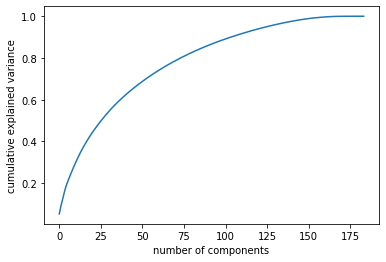

In [29]:
# Write your code here
pca = PCA(random_state=np.random.RandomState(42))

pca.fit(transformeed_courses)
print(transformeed_courses.shape)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


We see that 150 components explain about 90% of the variance in the dataset. Thus, those 100 components might be sufficient for our downstream tasks like prediction. 


In [30]:
def getNoOfComponentsAt95Perc(result):
    # number of components sufficient to explain 95% of the variance
    arr = np.cumsum(result) > 0.95
    return np.where(arr == True)[0][0]


# featureTransformer => StandardScaler() => PCA
pipeFeaturesTransformerPca = Pipeline([('featureTransformer', featureTransformer),
                                      ('pca', PCA(n_components=getNoOfComponentsAt95Perc(
                                          pca.explained_variance_ratio_), random_state=np.random.RandomState(42), svd_solver='randomized')),
                                       ])


pipeFeaturesTransformerPca.fit(courses)


Pipeline(steps=[('featureTransformer',
                 FeatureUnion(transformer_list=[('workload_processing',
                                                 Pipeline(steps=[('wrkld',
                                                                  <__main__.WorkloadTransformer object at 0x000001DC790B3288>)])),
                                                ('info_processing',
                                                 Pipeline(steps=[('info',
                                                                  <__main__.InfoTransformer object at 0x000001DC790B3188>)])),
                                                ('spec_processing',
                                                 Pipeline(steps=[('col_spec',
                                                                  ColumnTransformer(transformers=[('impute_specialisation',
                                                                                                   SimpleImputer(fill_value='Other',
           

In [31]:
# Retrain K neightbors model
K = 10
pca_model = NearestNeighbors(algorithm="brute", n_neighbors=K)
transformeed_courses_pca = pipeFeaturesTransformerPca.transform(courses)
training_data = pd.DataFrame(transformeed_courses_pca)
training_data.index = courses.code

pca_model.fit(training_data.values)


NearestNeighbors(algorithm='brute', n_neighbors=10)

In [32]:
K = 10
average_precision_score, average_recall_score = calAveragePrecisionRecallHelperAtK(
    pca_model, pipeFeaturesTransformerPca, K)
print('After PCA')
print('#########'*2)
print('Solved at K =', K,)
print('Average precision score', average_precision_score)
print('Average recall score', average_recall_score)
print('#########'*2)


After PCA
##################
Solved at K = 10
Average precision score 0.1159
Average recall score 0.12371281427550779
##################


Extend the code to perform a grid search for the value of `K` that provides the best `F1_score`. Try for values of K from 1 to 10.

                                                                                                     (2 marks)

In [33]:
# Write your code here

def f1(p, r):
    if p + r == 0:
        return 0
    else:
        return 2 * (p * r) / (p + r)

F1_score = []
Krange = range(1,11)
for K in Krange:
    average_precision_score, average_recall_score = calAveragePrecisionRecallHelperAtK(
        pca_model, pipeFeaturesTransformerPca, K)
    F1_score.append(f1(average_precision_score,average_recall_score))



Text(0.5, 0, 'K Value')

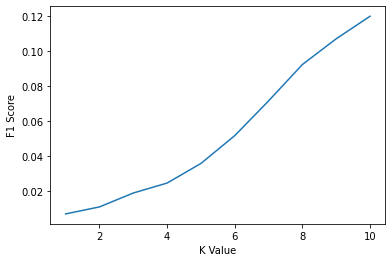

In [34]:
plt.plot(Krange, F1_score)
plt.ylabel('F1 Score')
plt.xlabel('K Value')


In [35]:
print('Max F1 Value:',max(F1_score))
print('K Value at Max F1 Score:',F1_score.index(max(F1_score))+1)

Max F1 Value: 0.11967903484531592
K Value at Max F1 Score: 10


# Bonus question

Can you provide some **concrete** (something that you can implement) suggestions to improve the performance of the system?

                                                                                                    (2 marks)

One of the efficiency in the model could be contributed by the transformation of `info` column using the CountVectorizer which generated 2000+ unique features made up of words appeared in all the `info` fields. Many of these features are words that has not much meaning such as, introduces, module, students etc. There one suggestion to improve the performace of the system is to filter out words that descibes the course out of all the noise. This would require some domain knowledge on what the words used to descibe a course. I am confident doing this would improve the performance of the system